In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
import warnings
warnings.filterwarnings('ignore') # seaborn shows a lot of ugly warnings, let's suppress this for the analysis part

In [3]:
sns.set() # set to seaborn default formatting

In [4]:
df = pd.read_csv('data/dc_housing/DC_Properties_training.csv', index_col=0, low_memory=False)

## 1 Feature Analysis

We have 47 features - way too many, and probably not all of the same quality. Let's cluster these into groups, analyse them one-by-one and drop the unnecessary ones.

```
-- rooms --
BATHRM Number of Full Bathrooms
HF_BATHRM Number of Half Bathrooms (no bathtub or shower)
ROOMS Number of Rooms
KITCHENS Number of kitchens
FIREPLACES Number of fireplaces
NUM_UNITS Number of Units
BEDRM Number of Bedrooms

-- building --
STORIES Number of stories in primary dwelling
GBA Gross building area in square feet
LIVING_GBA Gross building area in square feet
STYLE Style
GRADE Grade
EXTWALL Extererior wall
ROOF Roof type
INTWALL Interior wall
HEAT Heating
AC Cooling
SOURCE Raw Data Source

-- construction --
YR_RMDL Year structure was remodeled
AYB The earliest time the main portion of the building was built
EYB The year an improvement was built more recent than actual year built
CNDTN Condition
STRUCT Structure
BLDG_NUM Building Number on Property

-- sales information --
SALEDATE Date of most recent sale
SALE_NUM Sale Number
QUALIFIED Qualified

-- geographical --
USECODE Property use code
LANDAREA Land area of property in square feet
GIS_LAST_MOD_DTTM Last Modified Date
CMPLX_NUM Complex number
FULLADDRESS Full Street Address
CITY City
STATE State
ZIPCODE Zip Code
NATIONALGRID Address location national grid coordinate spatial address
LATITUDE Latitude
LONGITUDE Longitude
ASSESSMENT_NBHD Neighborhood ID
ASSESSMENT_SUBNBHD Subneighborhood ID
CENSUS_TRACT Census tract
CENSUS_BLOCK Census block
WARD Ward (District is divided into eight wards, each with approximately 75,000 residents)
SQUARE Square (from SSL)
X longitude
Y latitude
QUADRANT City quadrant (NE,SE,SW,NW)

-- price --
PRICE Price of most recent sale

```

### 1.1 Price Analysis

Let's look at the number of filled values per column:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157457 entries, 0 to 158956
Data columns (total 48 columns):
BATHRM                157457 non-null int64
HF_BATHRM             157457 non-null int64
HEAT                  157457 non-null object
AC                    157457 non-null object
NUM_UNITS             105670 non-null float64
ROOMS                 157457 non-null int64
BEDRM                 157457 non-null int64
AYB                   157189 non-null float64
YR_RMDL               80156 non-null float64
EYB                   157457 non-null int64
STORIES               105626 non-null float64
SALEDATE              130951 non-null object
PRICE                 97302 non-null float64
QUALIFIED             157457 non-null object
SALE_NUM              157457 non-null int64
GBA                   105670 non-null float64
BLDG_NUM              157457 non-null int64
STYLE                 105670 non-null object
STRUCT                105670 non-null object
GRADE                 105670 non-null

It seems we don't have the target value ```PRICE``` for all records. We thus should restrict the data set to only the records where we actually have a price.

In [6]:
df = df[~np.isnan(df['PRICE'])] # this brings us down to 97'302 rows

In [7]:
df['PRICE'].describe()

count    9.730200e+04
mean     9.276499e+05
std      7.033661e+06
min      1.000000e+00
25%      2.400000e+05
50%      3.999990e+05
75%      6.520000e+05
max      1.374275e+08
Name: PRICE, dtype: float64

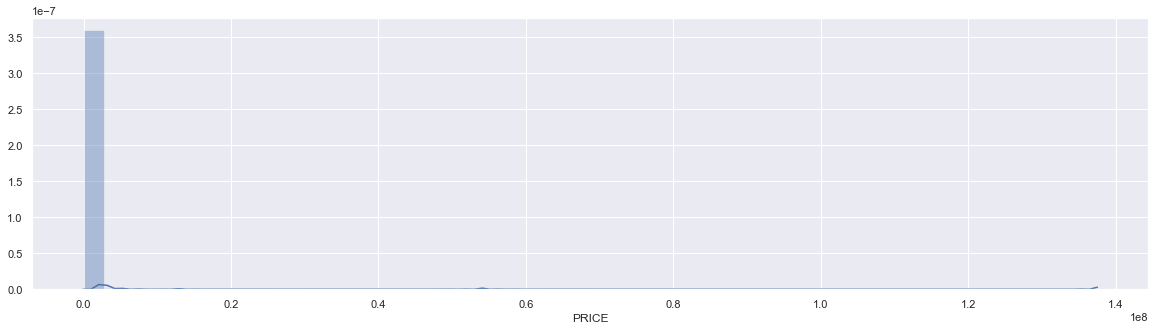

In [8]:
plt.subplots(figsize=(20,5))
sns.distplot(df['PRICE']);

It seems we have outliers in the price. Let's remove rows with prices lower than 20'000 and everything outside two standard deviations:

In [9]:
df = df[df['PRICE'] >= 20000]
df = df[np.abs(df['PRICE'] - df['PRICE'].mean()) <= (1.2*df['PRICE'].std())]

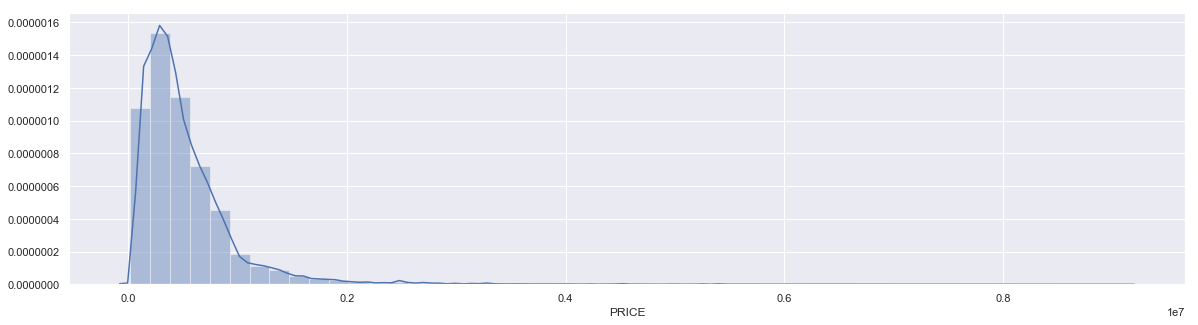

In [10]:
plt.subplots(figsize=(20,5));
sns.distplot(df['PRICE']);

Looks much better now. We have now 96'684 rows, so still a lot.

### 1.2 Rooms Analysis

```
BATHRM Number of Full Bathrooms
HF_BATHRM Number of Half Bathrooms (no bathtub or shower)
ROOMS Number of Rooms
KITCHENS Number of kitchens
FIREPLACES Number of fireplaces
NUM_UNITS Number of Units
BEDRM Number of Bedrooms
```

In [11]:
df.loc[:,['BATHRM','HF_BATHRM','ROOMS','KITCHENS','FIREPLACES','NUM_UNITS','BEDRM']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96684 entries, 0 to 158955
Data columns (total 7 columns):
BATHRM        96684 non-null int64
HF_BATHRM     96684 non-null int64
ROOMS         96684 non-null int64
KITCHENS      57242 non-null float64
FIREPLACES    96684 non-null int64
NUM_UNITS     57243 non-null float64
BEDRM         96684 non-null int64
dtypes: float64(2), int64(5)
memory usage: 5.9 MB


It seems we have complete data for all columns. Good. Let's have a look at the correlation between room sizes and the price (and at the same time detect outliers).

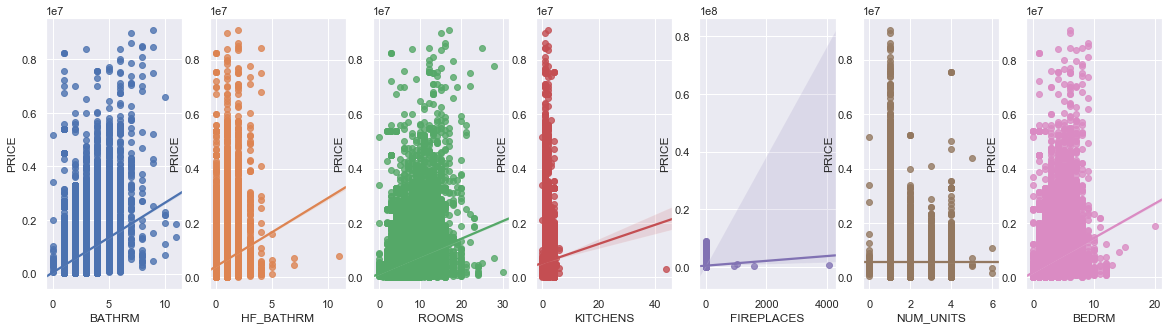

In [12]:
fig, axs = plt.subplots(ncols=7, figsize=(20,5))
sns.regplot(df['BATHRM'], df['PRICE'], ax=axs[0]);
sns.regplot(df['HF_BATHRM'], df['PRICE'], ax=axs[1]);
sns.regplot(df['ROOMS'], df['PRICE'], ax=axs[2]);
sns.regplot(df['KITCHENS'], df['PRICE'], ax=axs[3]);
sns.regplot(df['FIREPLACES'], df['PRICE'], ax=axs[4]);
sns.regplot(df['NUM_UNITS'], df['PRICE'], ax=axs[5]);
sns.regplot(df['BEDRM'], df['PRICE'], ax=axs[6]);

It seems we have a couple of odd properties in our data set. Let's drop the ones with 45 (!) kitchen, 4'000 fireplaces and other exotic dwellings.

In [13]:
df = df[(df['HF_BATHRM'] <= 5) & 
        ((df['KITCHENS'] < 10) | (np.isnan(df['KITCHENS']))) & # many rows seem to have no kitchen, so we need to consider this
        (df['FIREPLACES'] < 500) & 
        (df['BEDRM'] < 20)]

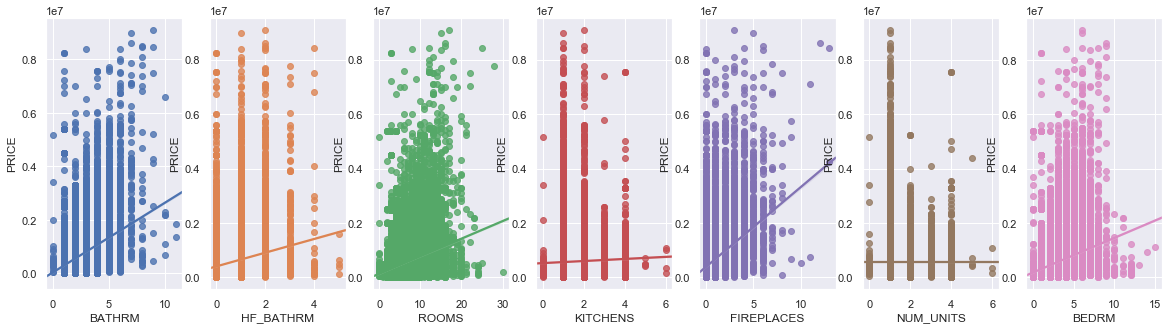

In [14]:
fig, axs = plt.subplots(ncols=7, figsize=(20,5))
sns.regplot(df['BATHRM'], df['PRICE'], ax=axs[0]);
sns.regplot(df['HF_BATHRM'], df['PRICE'], ax=axs[1]);
sns.regplot(df['ROOMS'], df['PRICE'], ax=axs[2]);
sns.regplot(df['KITCHENS'], df['PRICE'], ax=axs[3]);
sns.regplot(df['FIREPLACES'], df['PRICE'], ax=axs[4]);
sns.regplot(df['NUM_UNITS'], df['PRICE'], ax=axs[5]);
sns.regplot(df['BEDRM'], df['PRICE'], ax=axs[6]);

Looks much better already. It seems that ```KITCHENS``` and ```NUM_UNITS```do not have an influence on the price, so it's safe to drop these. We note these at the bottom of the data preparation part as we will build this into the pipeline. Now let's look at how the remaining features correlate with each other; this might allow us to drop some of them.

In [15]:
corr = round(df.loc[:,['BATHRM', 'HF_BATHRM', 'ROOMS', 'FIREPLACES', 'BEDRM']].corr(),2)
corr

,BATHRM,HF_BATHRM,ROOMS,FIREPLACES,BEDRM
BATHRM,1.00,0.29,0.71,0.42,0.71
HF_BATHRM,0.29,1.00,0.39,0.34,0.41
ROOMS,0.71,0.39,1.00,0.38,0.85
FIREPLACES,0.42,0.34,0.38,1.00,0.38
BEDRM,0.71,0.41,0.85,0.38,1.00


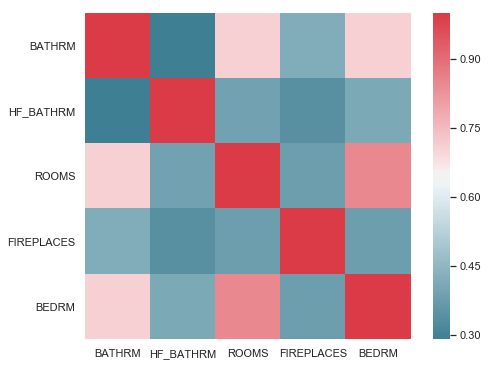

In [16]:
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);

We see that ```ROOMS```, ```BDRM``` and ```BATHRM```are correlated between 0.7 and 0.85. Although this as quite a strong correlation let's keep all of these as we have data for all records. The other variables ```HF_BATHRM``` and ```FIREPLACES``` are not correlated to the other variables, but with the ```PRICE```, so let's keep all of them. Just for completeness we also can look at a nice pairplot:

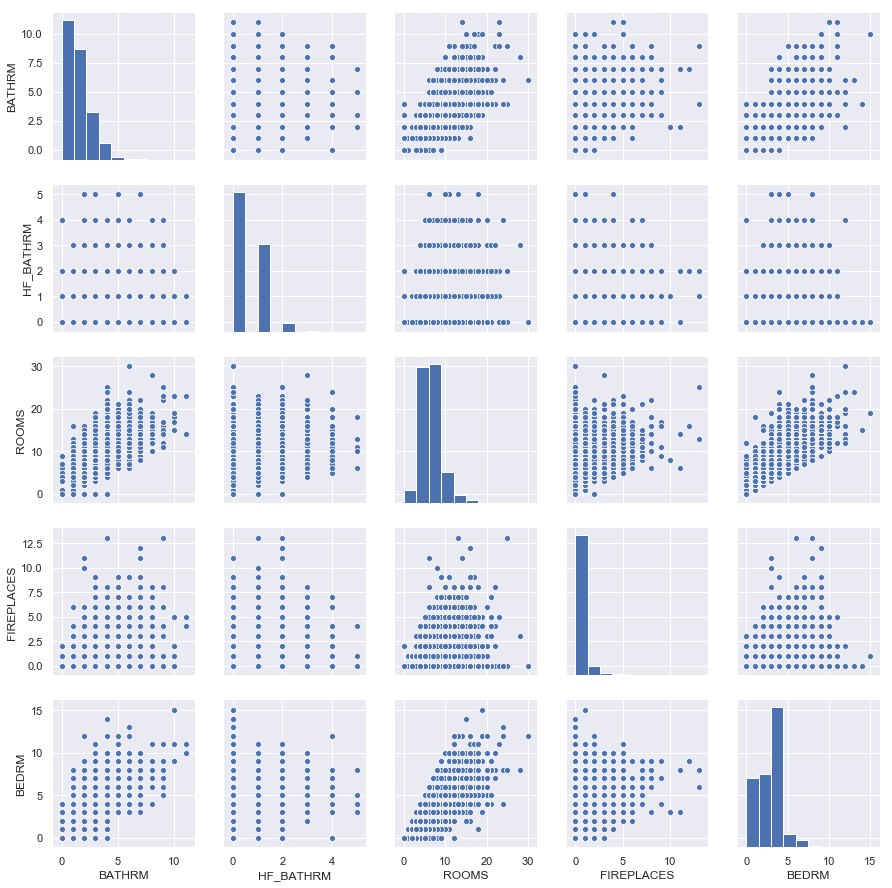

In [17]:
sns.pairplot(df.loc[:,['BATHRM', 'HF_BATHRM', 'ROOMS', 'FIREPLACES', 'BEDRM']]);

### 1.3 Rooms Analysis

```
STORIES Number of stories in primary dwelling
GBA Gross building area in square feet
LIVING_GBA Gross building area in square feet
STYLE Style
GRADE Grade
EXTWALL Extererior wall
ROOF Roof type
INTWALL Interior wall
HEAT Heating
AC Cooling
SOURCE Raw Data Source
```

In [18]:
df_rooms = df.loc[:,['STORIES','GBA','LIVING_GBA','STYLE','GRADE','EXTWALL','ROOF','INTWALL','HEAT','AC','SOURCE','PRICE']]

In [19]:
df_rooms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96675 entries, 0 to 158955
Data columns (total 12 columns):
STORIES       57205 non-null float64
GBA           57238 non-null float64
LIVING_GBA    39437 non-null float64
STYLE         57238 non-null object
GRADE         57238 non-null object
EXTWALL       57238 non-null object
ROOF          57238 non-null object
INTWALL       57238 non-null object
HEAT          96675 non-null object
AC            96675 non-null object
SOURCE        96675 non-null object
PRICE         96675 non-null float64
dtypes: float64(4), object(8)
memory usage: 12.1+ MB


It seems we don't have data for all the 94k rows. It's a bit suspicious that they all seem to have almost the same number of missing values. Let's do a spot-check:

In [20]:
df_rooms.sample(10, random_state=1)

,STORIES,GBA,LIVING_GBA,STYLE,GRADE,EXTWALL,ROOF,INTWALL,HEAT,AC,SOURCE,PRICE
index,,,,,,,,,,,,
59416,2.0,1440.0,NaN,2 Story,Average,Common Brick,Built Up,Hardwood,Hot Water Rad,N,Residential,265000.0
94183,2.0,832.0,NaN,2 Story,Average,Common Brick,Comp Shingle,Wood Floor,Forced Air,Y,Residential,324000.0
81354,2.0,1262.0,NaN,2 Story,Average,Common Brick,Built Up,Hardwood,Hot Water Rad,N,Residential,385000.0
121767,NaN,NaN,859.0,NaN,NaN,NaN,NaN,NaN,Forced Air,Y,Condominium,475000.0
123542,NaN,NaN,833.0,NaN,NaN,NaN,NaN,NaN,Forced Air,Y,Condominium,149900.0
60600,2.0,1768.0,NaN,2 Story,Good Quality,Common Brick,Built Up,Hardwood,Forced Air,Y,Residential,1050000.0
136508,NaN,NaN,1280.0,NaN,NaN,NaN,NaN,NaN,Wall Furnace,N,Condominium,155591.0
141974,NaN,NaN,943.0,NaN,NaN,NaN,NaN,NaN,Ht Pump,Y,Condominium,416000.0
18992,2.0,1896.0,NaN,2 Story,Superior,Common Brick,Metal- Sms,Hardwood,Warm Cool,Y,Residential,1250000.0


It seems all the condominiums are missing the ```STORIES```, ```GBA```, ```STYLE```, ```GRADE```, ```EXTWALL```, ```ROOF``` and  ```INTWALL```. We assume that all of these except ```GRADE``` do not have a major influence. Let's check this, and also include the ```LIVING_GBA``` in the correlation check.

In [21]:
corr = round(df_rooms.loc[:,['STORIES', 'GBA', 'LIVING_GBA', 'PRICE']].corr(),2)
corr

,STORIES,GBA,LIVING_GBA,PRICE
STORIES,1.00,0.04,NaN,0.04
GBA,0.04,1.00,NaN,0.61
LIVING_GBA,NaN,NaN,1.00,0.53
PRICE,0.04,0.61,0.53,1.00


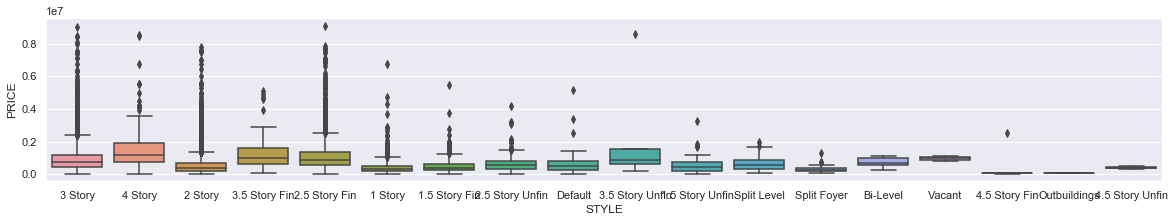

In [22]:
f, ax = plt.subplots(figsize=(20, 3))
fig = sns.boxplot(x='STYLE', y='PRICE', data=df_rooms)

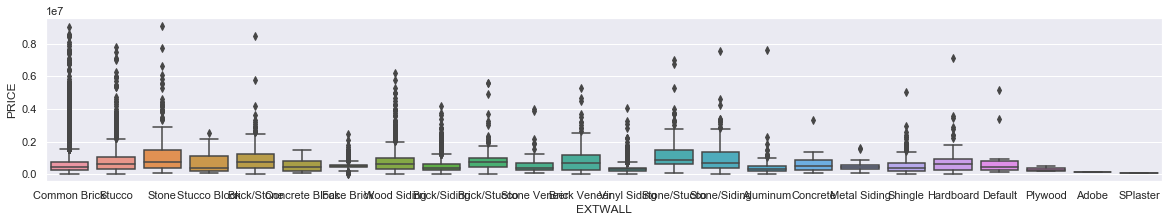

In [23]:
f, ax = plt.subplots(figsize=(20, 3))
fig = sns.boxplot(x='EXTWALL', y='PRICE', data=df_rooms)

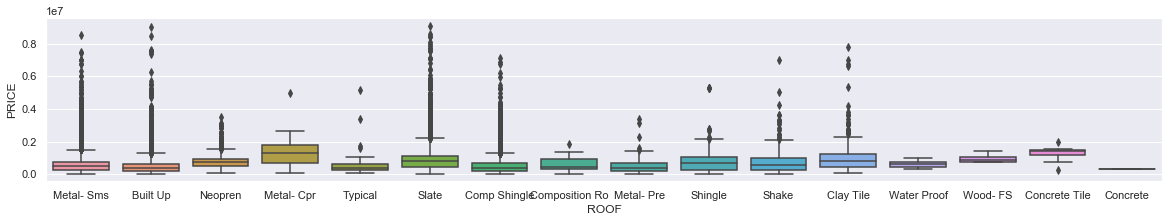

In [24]:
f, ax = plt.subplots(figsize=(20, 3))
fig = sns.boxplot(x='ROOF', y='PRICE', data=df_rooms)

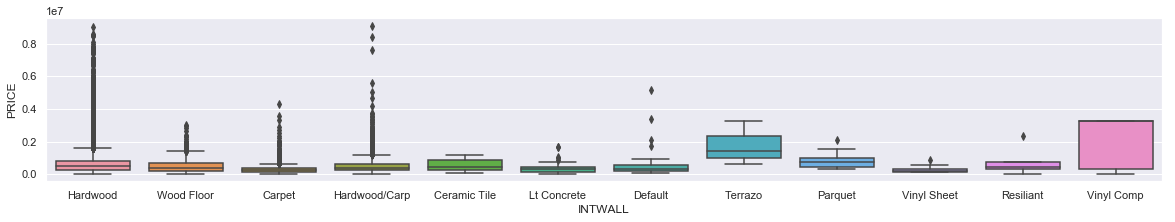

In [25]:
f, ax = plt.subplots(figsize=(20, 3))
fig = sns.boxplot(x='INTWALL', y='PRICE', data=df_rooms)

This partly confirms our assumption. Let's add all features except ```GBA``` and ```LIVING_GBA``` to the list of features to be dropped. In the pipeline, we will combine ```GBA``` and ```LIVING_GBA``` into one feature. Let's now look at the ```GRADE```feature:

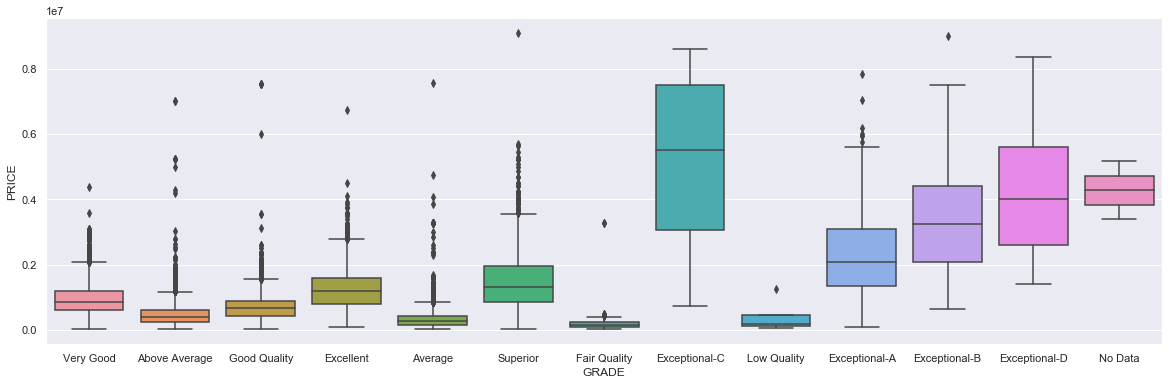

In [26]:
f, ax = plt.subplots(figsize=(20, 6))
fig = sns.boxplot(x='GRADE', y='PRICE', data=df_rooms)

In [27]:
grade_ordered = ['Low Quality',
                 'Fair Quality',
                 'Average',
                 'Above Average',
                 'Good Quality',
                 'Very Good',
                 'Excellent',
                 'Superior',
                 'Exceptional-A',
                 'Exceptional-B',
                 'No Data',
                 'Exceptional-D',
                 'Exceptional-C']
df_rooms['GRADE_NUM'] = df_rooms['GRADE'].astype("category", ordered=True, categories=grade_ordered).cat.codes

In [28]:
df_rooms_res = df_rooms[df_rooms['SOURCE']=='Residential']
round(df_rooms_res.loc[:,['GRADE_NUM', 'PRICE']].corr(),2)

,GRADE_NUM,PRICE
GRADE_NUM,1.00,0.66
PRICE,0.66,1.00


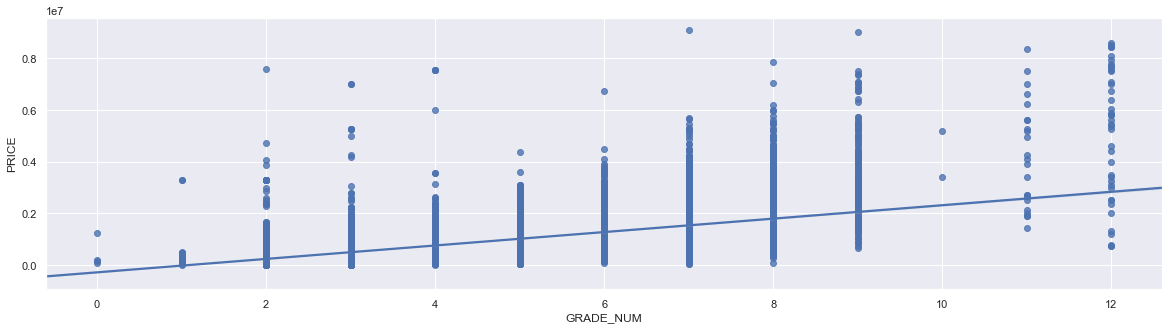

In [29]:
plt.subplots(figsize=(20,5));
sns.regplot(df_rooms_res['GRADE_NUM'], df_rooms_res['PRICE']);

The grade indeed correlates with the price. We should convert it into a numerical value though, or might even bucket it into more coarse categories (bad, medium, good). For now numerical values will do fine. We need to think about what we will do for condominiums which don't have a grade (probably assign a special category for these).

Let's now check the influence of the last three features, ```HEAT``` , ```AC``` and ```SOURCE```:

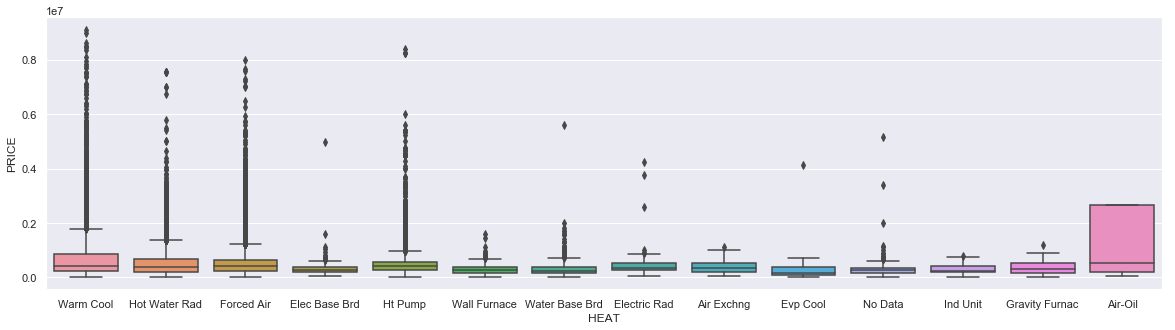

In [31]:
fig, axs = plt.subplots(figsize=(20,5))
fig = sns.boxplot(x='HEAT', y='PRICE', data=df_rooms);

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5))
fig = sns.boxplot(x='AC', y='PRICE', data=df_rooms, ax=axs[1]);
fig = sns.boxplot(x='SOURCE', y='PRICE', data=df_rooms, ax=axs[2]);

It seems that ```HEAT``` is very complicated and confuse, so let's drop it. ```AC``` and ```SOURCE``` seem to have a bit of an influence. We should correct the 0 values for ```AC``` though and set them to N.

### 1.4 Construction

```
YR_RMDL Year structure was remodeled
AYB The earliest time the main portion of the building was built
EYB The year an improvement was built more recent than actual year built
CNDTN Condition
STRUCT Structure
BLDG_NUM Building Number on Property
```

In [ ]:
df_cons = df.loc[:,['YR_RMDL', 'AYB', 'EYB', 'CNDTN', 'STRUCT', 'BLDG_NUM', 'PRICE', 'SOURCE']]
df_cons.info()

In [ ]:
df_cons.sample(10, random_state=1)

It seems that we again have features which are available only for residential buildings (the ```CNDTN``` and ```STRUCT```). Let's have a quick look at these first:

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5))
fig = sns.boxplot(x='CNDTN', y='PRICE', data=df_cons, ax=axs[0]);
fig = sns.boxplot(x='STRUCT', y='PRICE', data=df_cons, ax=axs[1]);

This is a somewhat inconclusive view. Let's drop them for now. We could probably do a bit of work on the ```CNDTN``` and group this, or at least transform it into scalar values. Let's look at the correlations of the other features:

In [ ]:
round(df_cons.loc[:,['YR_RMDL', 'AYB', 'EYB', 'BLDG_NUM', 'PRICE']].corr(),2)

In [ ]:
sns.pairplot(df_cons.loc[:,['YR_RMDL', 'AYB', 'EYB', 'BLDG_NUM', 'PRICE']]);

This is all not so explanatory. We should keep only ```EYB``` and remove  ```YR_RMDL```, ```AYB``` and ```BLDG_NUM```.

### 1.5 Sales

```
SALEDATE Date of most recent sale
SALE_NUM Sale Number
QUALIFIED Qualified
```

In [ ]:
df_sale = df.loc[:,['SALEDATE','SALE_NUM','QUALIFIED','SOURCE','PRICE']]
df_sale.info()

In [ ]:
df_sale.sample(5, random_state=1)

Let's look at the individual features:

In [ ]:
round(df_sale.loc[:,['SALE_NUM','PRICE']].corr(),2)

In [ ]:
fig = sns.boxplot(x='QUALIFIED', y='PRICE', data=df_sale)

In [ ]:
df_sale['SALEDATE'] = pd.to_datetime(df_sale['SALEDATE'], format='%Y-%m-%d', errors='coerce')

In [ ]:
plt.subplots(figsize=(20,5));
sns.lineplot(x="SALEDATE", y="PRICE", hue="SOURCE", data=df_sale);

In [ ]:
df_sale.sort_values(by='SALEDATE').tail()
df_sale = df_sale[~df_sale['SALEDATE'].isnull()]
df_sale['YEAR'] = df_sale['SALEDATE'].dt.year
round(df_sale.loc[:,['YEAR','PRICE']].corr(),2)

The ```SALE_NUM``` and ```QUALIFIED``` features do not have a visible correlation with ```PRICE```, so let's drop them. For ```SALEDATE```, we do have a small positive correlation (and we had to remove one record with no date), thus we keep it. We transform it into the year only and separate it into buckets with [<2003], [2003, 2011] and [>2011].

### 1.6 Geographical

```
USECODE Property use code
LANDAREA Land area of property in square feet
GIS_LAST_MOD_DTTM Last Modified Date
CMPLX_NUM Complex number
FULLADDRESS Full Street Address
CITY City
STATE State
ZIPCODE Zip Code
NATIONALGRID Address location national grid coordinate spatial address
LATITUDE Latitude
LONGITUDE Longitude
ASSESSMENT_NBHD Neighborhood ID
ASSESSMENT_SUBNBHD Subneighborhood ID
CENSUS_TRACT Census tract
CENSUS_BLOCK Census block
WARD Ward (District is divided into eight wards, each with approximately 75,000 residents)
SQUARE Square (from SSL)
X longitude
Y latitude
QUADRANT City quadrant (NE,SE,SW,NW)
```

There are a couple of features we can safely drop:
```
GIS_LAST_MOD_DTTM
FULLADDRESS
CITY
STATE
SQUARE
X
Y
```

We assume that ```LATITUDE``` and ```LONGITUDE``` is more than covered by the categorical features, so let's drop these as well. 

In [ ]:
df_geo = df.loc[:,['USECODE',
                  'LANDAREA',
                  'CMPLX_NUM',
                  'ZIPCODE',
                  'NATIONALGRID',
                  'ASSESSMENT_NBHD',
                  'ASSESSMENT_SUBNBHD',
                  'CENSUS_TRACT',
                  'CENSUS_BLOCK',
                  'WARD',
                  'QUADRANT',
                  'PRICE']]
df_geo.info()

We don't have enough data for ```CMPLX_NUM```, ```NATIONALGRID``` and ```CENSUS_BLOCK```, and we assume that ```ASSESSMENT_SUBNBHD```is too granulary anyway; so let's remove all these as well.

In [ ]:
df_geo.drop(['CMPLX_NUM', 'NATIONALGRID', 'CENSUS_BLOCK', 'ASSESSMENT_SUBNBHD'], axis=1, inplace=True)

In [ ]:
df_geo.sample(5, random_state=1)

Let's now check to what extent the other features influence the price.

In [ ]:
f, ax = plt.subplots(figsize=(20, 3))
fig = sns.boxplot(x='USECODE', y='PRICE', data=df_geo)

In [ ]:
plt.subplots(figsize=(20,5));
sns.regplot(df_geo['LANDAREA'], df_geo['PRICE']);

In [ ]:
f, ax = plt.subplots(figsize=(20, 3))
fig = sns.boxplot(x='ZIPCODE', y='PRICE', data=df_geo)

In [ ]:
f, ax = plt.subplots(figsize=(20, 3))
fig = sns.boxplot(x='ASSESSMENT_NBHD', y='PRICE', data=df_geo)

In [ ]:
f, ax = plt.subplots(figsize=(20, 3))
fig = sns.boxplot(x='CENSUS_TRACT', y='PRICE', data=df_geo)

In [ ]:
f, ax = plt.subplots(figsize=(20, 3))
fig = sns.boxplot(x='WARD', y='PRICE', data=df_geo)

In [ ]:
f, ax = plt.subplots(figsize=(20, 3))
fig = sns.boxplot(x='QUADRANT', y='PRICE', data=df_geo)

The ```LANDAREA``` feature is something we should for sure keep as it has a positive correlation with the price. All the other features are very granular categorical features; we would need to cluster them. Let's drop them for now and keep ```...``` in the waiting list for bucketing in case our model is not performing well. The ```ZIPCODE``` would be the natural candidate.

### 1.7 Data Analysis Summary

##### List of Features to be Dropped in Pipeline
```
KITCHENS
NUM_UNITS
STORIES
STYLE
EXTWALL
ROOF
INTWALL
HEAT
CNDTN
STRUCT
YR_RMDL
BLDG_NUM
AYB
SALE_NUM
QUALIFIED
GIS_LAST_MOD_DTTM
FULLADDRESS
CITY
STATE
X
Y
LATITUDE
LONGITUDE
CMPLX_NUM
NATIONALGRID
CENSUS_BLOCK
ASSESSMENT_SUBNBHD
USECODE
ASSESSMENT_NBHD
CENSUS_TRACT
WARD
SQUARE
QUADRANT
ZIPCODE
```

##### List of Features Needed in Pipeline
```
numerical:
BATHRM
HF_BATHRM
ROOMS
BEDRM
FIREPLACES
YEAR
EYB
GBA
LANDAREA

ordinal:
GRADE

categorical:
AC
SOURCE
```

##### List of Features Requiring Engineered in Pipeline
```
GBA / LIVING_GBA   merge into one column
GRADE              convert to numerical values as GRADE_NUM
AC                 convert 0 to N
SALEDATE           convert to YEAR
```

##### Candidates for Additional Feature Engineering in Pipeline
```
CNDTN              bucket into bad / medium / good
SALEDATE           bucket into decades
ZIPCODE            bucket into rich / medium / poor
```

From the original 47 features we remove 33, leaving us with 14. Out of these fourteen, we will need to transform five. We will do these transformations as part of the pipeline.